MA1415 Assignment Robusta Metoder 24/5-2025 Petter Eriksson

# 1. Visual Exploration

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [3]:
# Load dataset from txt file
series = pd.read_csv('CACONDE.txt', header=None, names=['useful_volume'])
series.index = pd.date_range(start='2000-01-01', periods=len(series), freq='ME')
series = series['useful_volume']

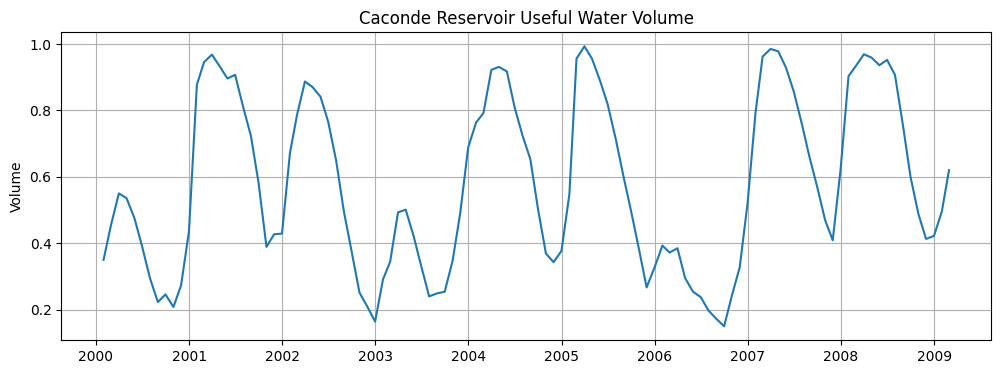

In [4]:
# Plot raw series
plt.figure(figsize=(12, 4))
plt.plot(series)
plt.title("Caconde Reservoir Useful Water Volume")
plt.ylabel("Volume")
plt.grid(True)
plt.show()

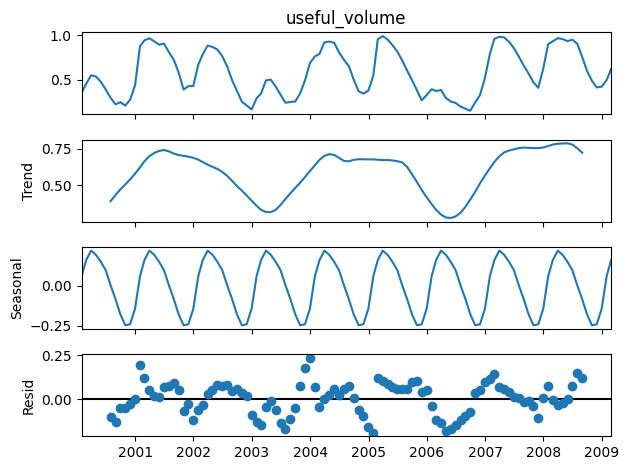

In [5]:
# Decompose seasonality and trend
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(series, model='additive', period=12)
decomposition.plot()
plt.show()

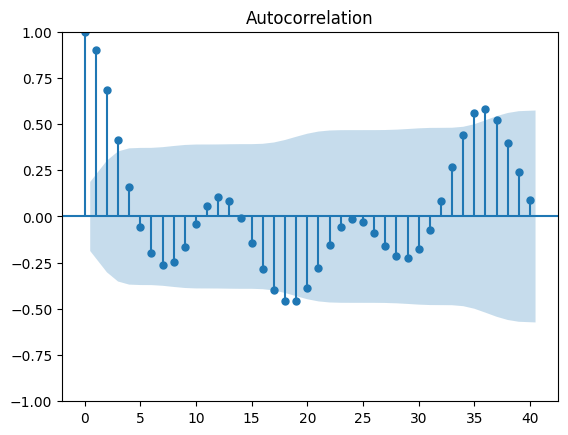

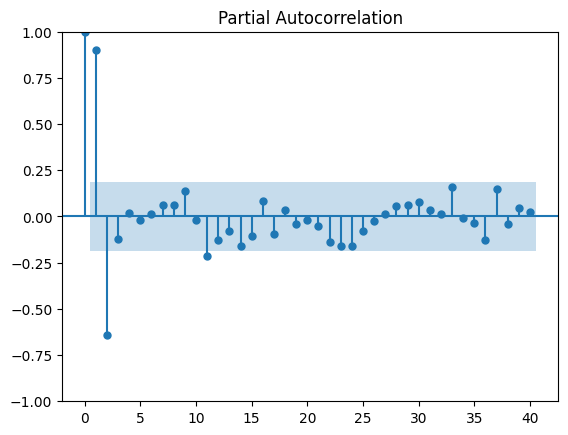

In [8]:
# ACF and PACF
plot_acf(series, lags=40)
plot_pacf(series, lags=40)
plt.show()

In [9]:
# 2. Test for Stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(series.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -5.21742147859973
p-value: 8.099886442653391e-06


In [10]:
# 3. Split Data
train = series[:-6]
valid = series[-6:]

In [11]:
# 4. AR Model (Dynamic Regression)
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(train, lags=12).fit()
ar_forecast = ar_model.predict(start=valid.index[0], end=valid.index[-1], dynamic=False)

In [13]:
# 5. ARMA Model with Seasonal Terms
from statsmodels.tsa.statespace.sarimax import SARIMAX
seasonal_order = (1, 0, 0, 12)
sin_term = np.sin(2 * np.pi * np.arange(len(series)) / 12)
cos_term = np.cos(2 * np.pi * np.arange(len(series)) / 12)

exog = pd.DataFrame({'sin': sin_term, 'cos': cos_term}, index=series.index)
arma_model = SARIMAX(train, exog=exog[:-6], order=(2, 0, 2)).fit()
arma_forecast = arma_model.predict(start=valid.index[0], end=valid.index[-1], exog=exog[-6:])


In [14]:
# 6. SARMA Model
sarma_model = SARIMAX(train, order=(2,0,2), seasonal_order=(1,0,1,12)).fit()
sarma_forecast = sarma_model.predict(start=valid.index[0], end=valid.index[-1])

/Users/pettereriksson/Documents/Programming/git_reps/MS1415/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


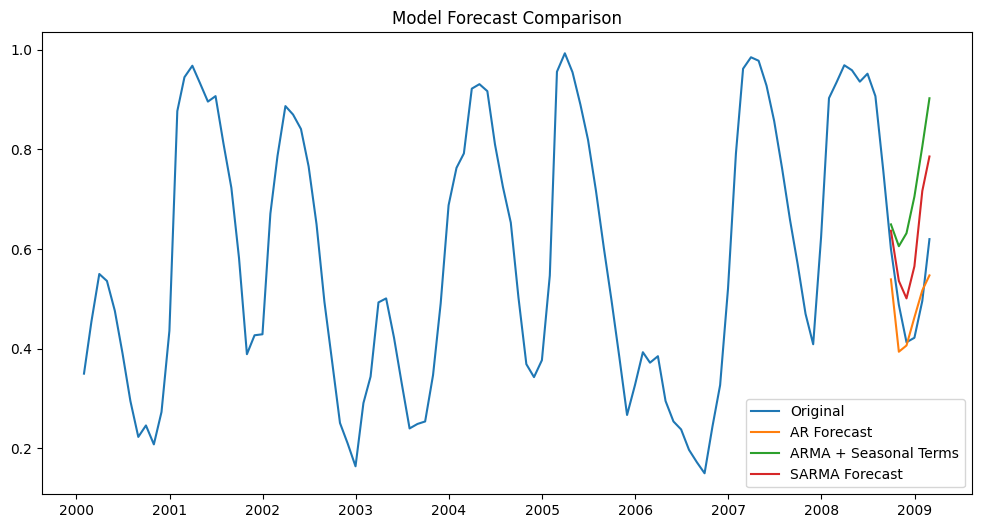

AR RMSE: 0.0577419429227716
ARMA RMSE: 0.23113692834503327
SARMA RMSE: 0.1342707193081347


In [16]:
# 7. Model Comparison
plt.figure(figsize=(12, 6))
plt.plot(series, label='Original')
plt.plot(ar_forecast, label='AR Forecast')
plt.plot(arma_forecast, label='ARMA + Seasonal Terms')
plt.plot(sarma_forecast, label='SARMA Forecast')
plt.legend()
plt.title("Model Forecast Comparison")
plt.show()

from sklearn.metrics import mean_squared_error
print("AR RMSE:", np.sqrt(mean_squared_error(valid, ar_forecast)))
print("ARMA RMSE:", np.sqrt(mean_squared_error(valid, arma_forecast)))
print("SARMA RMSE:", np.sqrt(mean_squared_error(valid, sarma_forecast)))